## About this code

This script describes a pipeline for the domain relevance classification algorithm.<br>
Input: a tweet or batch of tweets<br>
Process: apply feature engineering, modeling and classification (0,1 - relevant or 2 - not relevant)<br>
Output: a classification per input. Relevance=0 means the tweet ragards Israel generally, '1' suggest political/religious context and '2' means irrelevant tweet (noise).
1. Using the Pipeline.py for pre-process, feature engineering (NLP, entities, user features) and feature selection
2. Classification - one problem of two classes ('2' and 'not 2'). 
3. Evaluation

RESULTS:<br>
**0 - RELEVANT, 1 - NOT RELEVANT**

# Table of Content

- <a href="#Run-configurations">Run configurations</a>
- <a href="#Data-import">Data import</a>
- <a href="#Run-pipeline">Run pipeline</a>
- <a href="#KDE-plots">KDE plots</a>
- <a href="#Phase-1--Relevance-to-domain">Phase 1- Relevance to domain</a>
    - <a href="#First-evaluation-('2'-vs.-all)">First evaluation ('2' vs. all)</a>
- <a href="#Phase-2---Relevance-type">Phase 2 - Relevance type</a>
    - <a href="#Remove-irrelevant-data">Remove irrelevant data</a>
    - <a href="#Adding-features">Adding features</a>
    - <a href="#Evaluation">Evaluation</a>

## Run configurations

In [1]:
config = {
            # Mode
            'learning': True,           # True at the train phase, False when operational - predict new data using existing model 
            
            # Data
            'filter_taggers': False,    # If to filter labeled data by the tagger - Yogev, Ofir and Itay
            'target': 'relevance',        # The target of the algorithm
            'load_df_from_pickle': False,  # If to load a ready data frame or to do the entire pipeline from the beginning 
            
            # Pre-process
            'slang': True,              # If to handle slang words, also for Feature engineering
            'spell_correction': False,  # If to use spell correction in the pre-proccess phase 
            'col': 'text',              # Column to apply pre-proccess on - used by the proccess_tweet function in tweet_pre_proccess.py
            
            # Feature engineering
            'nlp_features': True,
            'dominant_keywords': True,
            'dominant_keywords_metric': 'entropy',
            'user_features': False,
            'time_and_event': False,    # Time and event features
            'network_features': False,
                'load_network_data': False,
            'nlp_raw': True,
            'sentiment': False,         #sentiment analysis feature. if false, dominant words feature won't be created also
            'emotion': False,           #emotion feature. will be false for the relevance classification
            'word_type': False,         #word class dict feature. will be false for the relevance classification 
            'hashtags_and_mentions': True,
            'num_dominant_words': 100,  # Number of dominant words to use in the NLP features (dominant_keywords function - parameter k)
            'min_word_appearances': 4,# Min number of appearnces (#tweets) for dominant word to be considered dominant
            'min_couple_appearances': 4,# For couple of dominant words -
                                        # how many time the combination need to appear in the data in order to become a feature        
            'url_features': False,
            'Tweets_media_and_content': True,
            'country_support': False,
            'entities_features': True,
    
            # Feature selection
            'feature_selection': True,
            'remove_features_zero_variance': True,        
            'remove_correlated_features': False,
            'remove_low_correlated_features': False,
            'feature_importance': True,
            'corr_per_thresh': 0.0,    # Percentile threshold of Min correlation between a feature and the target variable (abs) 
            'importance_per_thresh': 25,# Percentile threshold of Min importance of a feature
            'PCA': False,               # If the use PCA to reduce dimensiality
            'PCA_var': 0.995,           # % of commulative explained variance required from PCA (affect #of PC)

            # Model
            'load_model_pickle': False, # If to import existing models from pickle
            'regression': False,        # If to run regression model also
            'validation': False,        # If to use train split to train and validation
            'class_threshold': 0.5,     # Probability threshold in order to classify a tweet as negative/neurtal/positive
            'bench_from_pickle': True
    }

Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import os
import glob
import csv
import time
import matplotlib
import pickle
from tqdm import tqdm, trange, tqdm_notebook, tqdm_pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
# Avoid trimming text in jupyter preview
pd.set_option('display.max_colwidth', -1)

In [4]:
# Set start time of the script
start = time.time()

In [5]:
plt.style.use('ggplot')
%matplotlib inline

In [6]:
np.random.seed = 1234
tqdm.pandas(tqdm_notebook())

#### Import thesis modules

In [7]:
os.chdir('../pipeline')
import domain_entities
import nlp_url_features
import tweet_pre_proccess
import nlp_features
import eda
import ml_model
import slang
import pipeline
os.chdir('../{} algo'.format(config['target']))

## Data import

In [8]:
labeled_data = pd.read_csv("../../data/classifiers/labeled_data.csv", header=0, encoding='utf-8')

In [9]:
# Filter bad taggers
labeled_data = labeled_data[labeled_data.Tagger.isin(['ofir','yogev','Itay'])] if config['filter_taggers'] else labeled_data

In [10]:
labeled_data.dtypes

Unnamed: 0     int64  
relevance      float64
support        float64
Tagger         object 
created_at     int64  
emotion        object 
screen_name    object 
text           object 
id             float64
dtype: object

In [11]:
data_tweets = labeled_data[['id','text','relevance','support','emotion','screen_name','created_at']]
data_tweets.reset_index()
# Remove tweets with no target label
data_tweets = data_tweets.dropna(subset=[config['target']])
if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    data_tweets = data_tweets[data_tweets['relevance']!=2]
else:
    del data_tweets['support']
    data_tweets['relevance'] = data_tweets['relevance'].apply(lambda x: int(x))

In [12]:
# Load csv
test_set = pd.read_csv('../../data/classifiers/test.csv', header=0, encoding='utf-8')
test_set = test_set[['id','text','relevance','support','emotion','screen_name','created_at']]

### Data balance

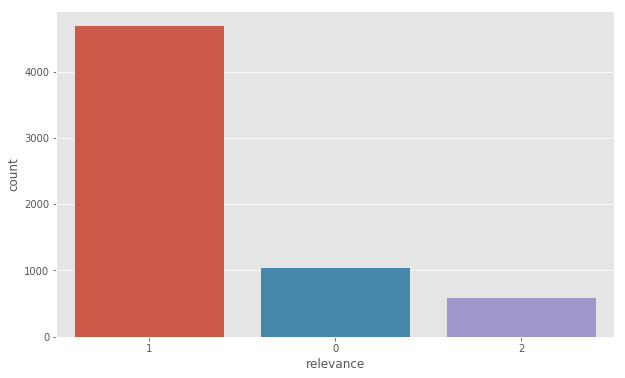

In [13]:
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
h = sns.countplot(x=config['target'], data=data_tweets, order = data_tweets[config['target']].value_counts().index)

In [14]:
data_tweets.head(n=1)

id  \
0  4.030000e+17   

                                                                                                                                                  text  \
0  "Join Students for Justice in Palestine (SJP UMN) this Wednesday at 4:30 pm with Josh Ruebner. His book ""Shattered... http://fb.me/2FbldzgdgÂ¬â€ "   

   relevance emotion   screen_name  created_at  
0  0          NaN     ampminnesota  1384803626

## Run pipeline

#### Run pipeling

----------------------
  - Lower case completed
  - Strip punctuation completed
  - Stop-words removal completed
  - Tokenization completed
  - Slang words correction completed
  - Stemming phase completed
  - Cleaning empty tokens completed
Final number of tagged tweets: 6308

COMPLETED: Pre-proccess | RUNTIME: 1551016602.55 sec
----------------------
----------------------
START: NLP features
 Raw NLP features
  - Word classes features doesnt need to be done (1/5)
  - Capital letters features completed (2/5)
  - 1 length words features completed (3/5)
  - Simple features completed (4/5)


100%|██████████| 6308/6308 [00:00<00:00, 301182.41it/s]


  - Negation words feature completed (5/5)

 Hashtags & Mentions
  - Mentions feature completed
  - Hashtags features completed

 Dominant keywords
 - Creating bag-of-words features
  - COMPLETED: 9504 columns created
Words frequency filter: -6854 word features removed
 - num_dominant_words
  - Dominant couples completed
  - Emotions * dominant words
  COMPLETED: Dominant words

 START: Entities features
 - COMPLETED

 Tweet's media and content features completed

COMPLETED: NLP features
----------------------
----------------------
Feature engineering COMPLETED

- - - - - - - - - - -
START: FEATURE SELECTION
- Removing features with std = 0
  - hash_#israstine
  - hash_#israelilivesmatter
  - hash_#greatreturnmarch
  - hash_#israelunderattack
  - hash_#wesupportisrael
  - hash_#standwithus
  - hash_#prayforisrael
  - hash_#israelforever
  - hash_#jewishlivesmatter
  - hash_#supportidf
  - hash_#jerusalemintifada
  - hash_#boycotteurovision
  - hash_#supportisrael
  - hash_#solidarityw

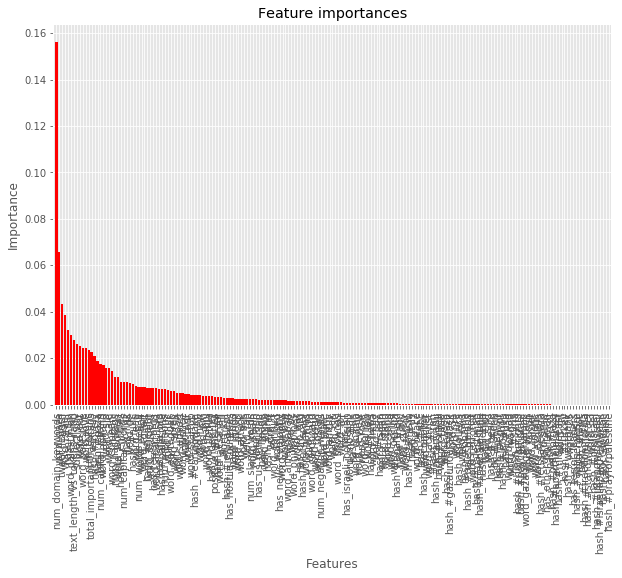

- Removing features with low importance
  Features before filtering: 194
  Features after filtering: 146
  Filtered coloumns:
['has_RT_req', 'word_terrorist', 'hash_#palestinian', 'hash_#freepalestine', 'hash_#flotilla', 'hash_#idf', 'word_silki', 'hash_#peace', 'hash_#cnn', 'hash_#jewish', 'hash_#egypt', 'hash_#lebanon', 'hash_#usa', 'word_blockad', 'word_magna', 'hash_#syria', 'hash_#humanrights', 'hash_#boycottisrael', 'hash_#hamas', 'word_gazaunderattack', 'word_occup', 'word_target', 'word_violenc', 'word_explain', 'hash_#letssavegaza', 'word_strip', 'has_other_politician', 'hash_#tcot', 'hash_#prayforgaza', 'hash_#apartheidisrael', 'hash_#middleeast', 'word_ml', 'hash_#turkey', 'hash_#westbank', 'word_25', 'has_terror_leaders', 'hash_#antisemitism', 'word_confisc', 'hash_#jews', 'hash_#freedomflotilla', 'hash_#standwithisrael', 'word_33', 'hash_#proisrael', 'hash_#istandwithisrael', 'hash_#israeliapartheidweek', 'hash_#occupation', 'hash_#israels', 'hash_#prayforpalestine']

COMP

In [15]:
df = pipeline.pipeline(data_tweets, config) if not config['load_df_from_pickle'] else pd.read_pickle('../../data/classifiers/support_pipeline_train.pkl')

Null values check

In [16]:
for col in data_tweets.columns:
    counter = data_tweets[col].isnull().sum().sum()
    print(col) if counter > 0 else None

emotion


In [17]:
if not config['load_df_from_pickle']:
    df.to_pickle('../../data/classifiers/support_pipeline_train.pkl')

Export final feature list (after feature selection) to picle.<br>
These features will be applied to new data at the production phase.

Show df

In [18]:
pd.set_option('display.max_columns', None)
df._get_numeric_data().describe()

word_nohigh     word_sex     word_jew     word_sjp    word_love  \
count  6308.000000  6308.000000  6308.000000  6308.000000  6308.000000   
mean   0.001110     0.001744     0.021560     0.123177     0.029962      
std    0.033296     0.041726     0.145253     0.328666     0.170496      
min    0.000000     0.000000     0.000000     0.000000     0.000000      
25%    0.000000     0.000000     0.000000     0.000000     0.000000      
50%    0.000000     0.000000     0.000000     0.000000     0.000000      
75%    0.000000     0.000000     0.000000     0.000000     0.000000      
max    1.000000     1.000000     1.000000     1.000000     1.000000      

       num_slang_words  word_activist  num_mentions  hash_#zionism  \
count  6308.000000      6308.000000    6308.000000   6308.000000     
mean   0.046607         0.012207       0.384274      0.003488        
std    0.259983         0.109816       0.746911      0.058958        
min    0.000000         0.000000       0.000000      0.000000        
25%    0.000000         0.000000       0.000000      0.000000        
50%    0.000000         0.000000       0.000000      0.000000        
75%    0.000000         0.000000       1.000000      0.000000        
max    4.000000         1.000000       8.000000      1.000000        

       word_attack    word_gaza      word_im     has_link  hash_#netanyahu  \
count  6308.000000  6308.000000  6308.000000  6308.000000  6308.000000       
mean   0.035669     0.230659     0.010780     0.631420     0.003012          
std    0.185478     0.421288     0.103274     0.482458     0.054804          
min    0.000000     0.000000     0.000000     0.000000     0.000000          
25%    0.000000     0.000000     0.000000     0.000000     0.000000          
50%    0.000000     0.000000     0.000000     1.000000     0.000000          
75%    0.000000     0.000000     0.000000     1.000000     0.000000          
max    1.000000     1.000000     1.000000     1.000000     1.000000          

         word_lord  hash_#earthquake  hash_#palestinians  subjectivity  \
count  6308.000000  6308.000000       6308.000000         6308.000000    
mean   0.002695     0.004439          0.005231            0.249999       
std    0.051847     0.066482          0.072145            0.311070       
min    0.000000     0.000000          0.000000            0.000000       
25%    0.000000     0.000000          0.000000            0.000000       
50%    0.000000     0.000000          0.000000            0.033333       
75%    0.000000     0.000000          0.000000            0.500000       
max    1.000000     1.000000          1.000000            1.000000       

         hash_#sjp   word_happi   hash_#land    word_kill      word_34  \
count  6308.000000  6308.000000  6308.000000  6308.000000  6308.000000   
mean   0.099398     0.003171     0.000793     0.045339     0.003488      
std    0.299219     0.056223     0.028145     0.208064     0.058958      
min    0.000000     0.000000     0.000000     0.000000     0.000000      
25%    0.000000     0.000000     0.000000     0.000000     0.000000      
50%    0.000000     0.000000     0.000000     0.000000     0.000000      
75%    0.000000     0.000000     0.000000     0.000000     0.000000      
max    1.000000     1.000000     1.000000     1.000000     1.000000      

         word_raid     word_bds  word_earthquak    word_nufc  word_cultiv  \
count  6308.000000  6308.000000  6308.000000     6308.000000  6308.000000   
mean   0.012999     0.056912     0.005390        0.002854     0.001110      
std    0.113280     0.231692     0.073224        0.053346     0.033296      
min    0.000000     0.000000     0.000000        0.000000     0.000000      
25%    0.000000     0.000000     0.000000        0.000000     0.000000      
50%    0.000000     0.000000     0.000000        0.000000     0.000000      
75%    0.000000     0.000000     0.000000        0.000000     0.000000      
max    1.000000     1.000000     1.000000        1.00000

In [19]:
# Search for np.nan 
for col in df.columns:
    temp = df[col].apply(lambda x: 1 if x == np.nan else 0)
    print('{}: {}'.format(col, temp.sum())) if temp.sum() > 0 else None

### KDE plots

In [20]:
# labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
#           'relevance': {'names': ['General', 'Political', 'Ignore'], 'values': [0,1,2]}}

# features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'tokenized_text'])]
# eda.kde_plots(df, features, config['target'], labels[config['target']]['names'])

## Phase 1- Relevance to domain

In [21]:
# Updated features list
features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'tokenized_text', 'id', 'created_at', 'screen_name'])]

In [22]:
with open('{}_features_list.pickle'.format(config['target']), 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Train-test split

#### Change configurations for test set build 

In [23]:
for attr in ['learning', 'feature_selection', 'remove_features_zero_variance', 'remove_correlated_features', 'remove_low_correlated_features', 'feature_importance']:
    config[attr] = False
config['min_word_appearances'], config['min_couple_appearances']= 0,0

In [24]:
# Remove tweets with no target label
test_set = test_set.dropna(subset=[config['target']])
if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    test_set = test_set[test_set['relevance']!=2]
else:
    del test_set['support']
    test_set['relevance'] = test_set['relevance'].apply(lambda x: int(x))

# Run pipeline on test set
test_set = pipeline.pipeline(test_set, config) if not config['load_df_from_pickle'] else pd.read_pickle('../../data/classifiers/relevance_pipeline_test.pkl')

----------------------
  - Lower case completed
  - Strip punctuation completed
  - Stop-words removal completed
  - Tokenization completed
  - Slang words correction completed
  - Stemming phase completed
  - Cleaning empty tokens completed
Final number of tagged tweets: 498

COMPLETED: Pre-proccess | RUNTIME: 1551017126.92 sec
----------------------
----------------------
START: NLP features
 Raw NLP features
  - Word classes features doesnt need to be done (1/5)
  - Capital letters features completed (2/5)
  - 1 length words features completed (3/5)
  - Simple features completed (4/5)


100%|██████████| 498/498 [00:00<00:00, 500302.61it/s]


  - Negation words feature completed (5/5)

 Hashtags & Mentions
  - Mentions feature completed
  - Hashtags features completed

 Dominant keywords
 - Bag-of-words features
 - num_dominant_words
  - Dominant couples completed
  - Emotions * dominant words
  COMPLETED: Dominant words

 START: Entities features
 - COMPLETED

 Tweet's media and content features completed

COMPLETED: NLP features
----------------------
----------------------
Feature engineering COMPLETED
Pipeline COMPLETED


In [25]:
if not config['load_df_from_pickle']:
    test_set.to_pickle('../../data/classifiers/relevance_pipeline_test.pkl')

In [26]:
df.reset_index(inplace=True)
test_set.reset_index(inplace=True)

In [27]:
x_train, y_train, x_test, y_test = df[features], df[config['target']], test_set[features], test_set[config['target']]

### Relevnce to domain classification

Best parameters are: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 250, 'n_jobs': -1, 'random_state': 1}
Model AUC: 0.940


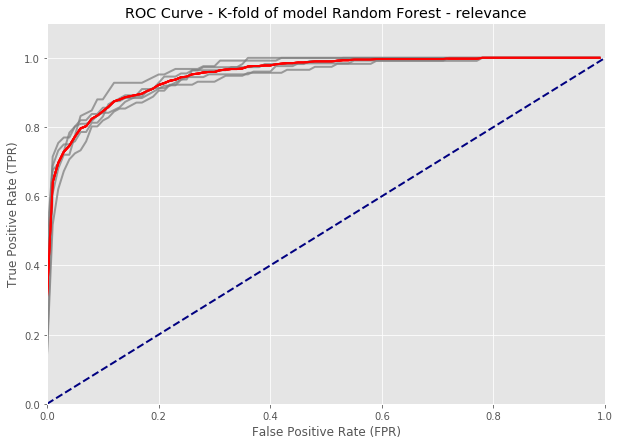

The average AUC over 5-folds is: 0.952
The average accuracy over 5-folds is: 95.13%
The MSE on the train set: 0.0205
The MSE on the test set: 0.0340


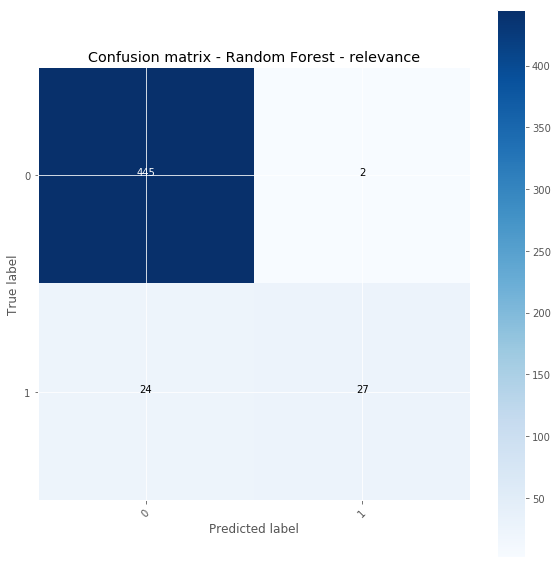

Accuracy on test: 0.95


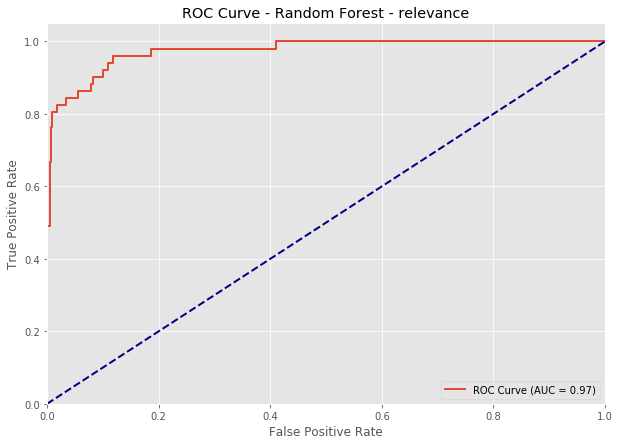

AUC achieved: 0.97


In [28]:
# Reset time
model_start = time.time()

# Parmeters grid to be checked
tuned_parameters = {'min_samples_split':[4, 8, 10, 15], 'max_depth':[5,15,20],'criterion':['gini', 'entropy'],
                   'n_estimators':[100,250,500], 'random_state':[1], 'n_jobs':[-1]}

if config['load_model_pickle']:
    with open('../../data/classifiers/relevance_model.pickle', 'rb') as handle:
        model = pickle.load(handle)
else:
    classes = {2: 'Irrelevant'}
    model = ml_model.run_ML_model(RandomForestClassifier, 'Random Forest - relevance', 2, x_train, x_test, y_train, y_test, tuned_parameters, 5, 'roc_auc', True)
    # Save models in a pickle file
    with open('../../data/classifiers/relevance_model.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

<div class="alert alert-block alert-success">
Only one instance of true relevant tweet was classified as non-relevant.<br>
</div>

## Evaluation ('2' vs. all)
Prepare for evaluation

In [29]:
# Use models to predict the test
prob_train = {}
prob_test = {}
# prob_external_test = {}
prob_train['prediction'] = model.predict(x_train)
prob_test['prediction'] = model.predict(x_test)
# prob_external_test['prediction'] = model.predict(x_external_test)

# Build data frames for all test predictions, from the relevance model
predictions_train = pd.DataFrame.from_dict(prob_train, orient='columns')
predictions_test = pd.DataFrame.from_dict(prob_test, orient='columns')
# predictions_external_test = pd.DataFrame.from_dict(prob_validation, orient='columns')

predictions_train['true_value'] = y_train.reset_index(drop=True)
predictions_train['true_value'] = predictions_train['true_value'].apply(lambda x: 0 if x!=2 else 1)

predictions_test['true_value'] = y_test.reset_index(drop=True)
predictions_test['true_value'] = predictions_test['true_value'].apply(lambda x: 0 if x!=2 else 1)

# predictions_external_test['true_value'] = y_external_test.reset_index(drop=True)
# predictions_external_test['true_value'] = predictions_external_test['true_value'].apply(lambda x: 0 if x!=2 else 1)

Evaluate

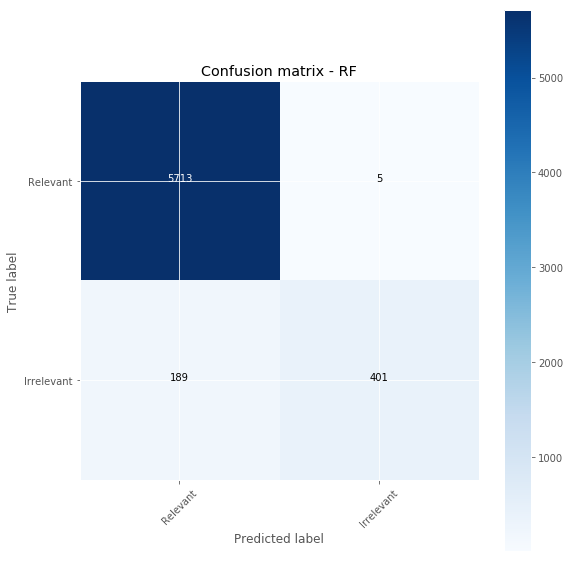

Accuracy on train: 0.97


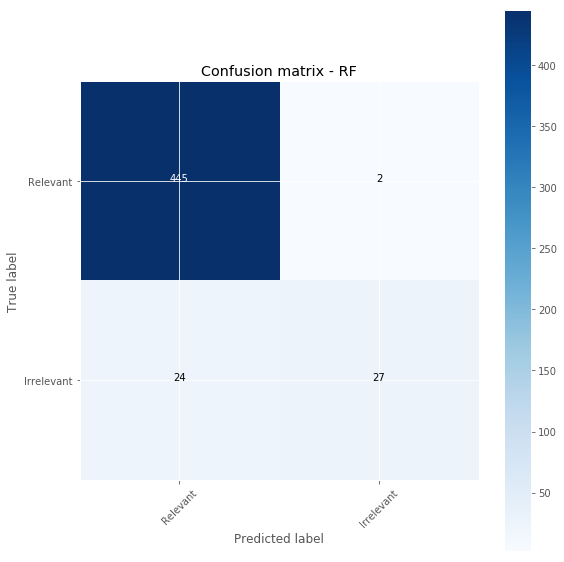

Accuracy on test: 0.95


In [30]:
labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
          'relevance': {'names': ['Relevant', 'Irrelevant'], 'values': [0,1]}}

ml_model.plot_confusion_matrix(list(predictions_train.prediction), list(predictions_train.true_value), 'RF', 'train', labels[config['target']])
ml_model.plot_confusion_matrix(list(predictions_test.prediction), list(predictions_test.true_value), 'RF', 'test', labels[config['target']])
#ml_model.plot_confusion_matrix(list(predictions_external_test.prediction), list(predictions_external_test.true_value), 'RF', 'external_test', labels[config['target']])

# calculate accuracy
accuracy_train = metrics.accuracy_score(list(predictions_train.true_value), list(predictions_train.prediction), normalize=True)
accuracy = metrics.accuracy_score(list(predictions_test.true_value), list(predictions_test.prediction), normalize=True)
# accuracy = metrics.accuracy_score(list(predictions_external_test.true_value), list(predictions_external_test.prediction), normalize=True)

In [31]:
with open('{}_features_list.pickle'.format(config['target']), 'rb') as handle:
    features = pickle.load(handle)
print('Final number of features: {}'.format(len(features)))
print('Feature list:\n')
print(sorted(features))

Final number of features: 141
Feature list:

['has_RT', 'has_anti_org', 'has_hostile_countries', 'has_image', 'has_israeli_politician', 'has_link', 'has_news_company', 'has_pro_org', 'has_terror_orgs', 'has_us_politician', 'has_video_ref', 'hash_#abc', 'hash_#apartheid', 'hash_#bds', 'hash_#earthquake', 'hash_#economy', 'hash_#freegaza', 'hash_#gaza', 'hash_#gazaunderattack', 'hash_#health', 'hash_#icc4israel', 'hash_#iran', 'hash_#islam', 'hash_#israel', 'hash_#israeli', 'hash_#jerusalem', 'hash_#land', 'hash_#lovely', 'hash_#nbc', 'hash_#netanyahu', 'hash_#news', 'hash_#nufc', 'hash_#obama', 'hash_#palestine', 'hash_#palestinians', 'hash_#politics', 'hash_#sjp', 'hash_#un', 'hash_#us', 'hash_#zionism', 'hostile_entities', 'num_capital_letters', 'num_capital_words', 'num_domain_keywords', 'num_hashtags', 'num_mentions', 'num_negation_words', 'num_slang_words', 'num_tokens', 'num_words_len_1', 'positive_entities', 'subjectivity', 'text_length_vs_tokens_ratio', 'total_important_hashtags